# Cas Kaggle - Predicció obessitat
https://www.kaggle.com/datasets/aravindpcoder/obesity-or-cvd-risk-classifyregressorcluster/data

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import time

from sklearn.linear_model import LogisticRegression, LinearRegression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import  DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer,accuracy_score



### Descripció de les variables
- Frequent consumption of high caloric food (FAVC)
- Frequency of consumption of vegetables (FCVC) 
- Number of main meals (NCP)
- Consumption of food between meals (CAEC)
- Consumption of water daily (CH20)
- Consumption of alcohol (CALC). 
- Calories consumption monitoring (SCC)
- Physical activity frequency (FAF)
- Time using technology devices (TUE)
- Transportation used (MTRANS)

## Dividir training i test

In [64]:
# Carregar el CSV en un DataFrame
df_full = pd.read_csv("ObesityDataSet.csv", encoding="utf-8")

# Mostrar les primeres files
df_full



,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


Dividim el dataset per 80(train + cv) - 20 test

In [65]:
# Dividir les dades en train i test
X = df_full[[col for col in df_full.columns if col != 'NObeyesdad']]
y = df_full['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1688, 16), (423, 16), (1688,), (423,))

## Explortory data analysis

In [66]:
# Crear un DataFrame que utilitzarem per entrenar i validar els models
df_split = pd.concat([X_train, y_train], axis=1)
# Crear un DataFrame que utilitzarem al final per provar el model triat
df_tester = pd.concat([X_test, y_test], axis=1)

# mostrem el conjunt d'entrenament i validació 
df_split


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
459,Male,19.000000,1.760000,79.000000,yes,yes,2.000000,3.000000,Frequently,no,3.000000,no,1.000000,2.000000,Frequently,Public_Transportation,Overweight_Level_I
426,Male,22.000000,1.750000,70.000000,no,no,2.000000,3.000000,Sometimes,no,3.000000,no,1.000000,1.000000,no,Public_Transportation,Normal_Weight
326,Male,18.000000,1.700000,55.300000,yes,yes,3.000000,3.000000,Sometimes,no,2.000000,no,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
971,Male,19.506389,1.824449,87.656029,yes,yes,2.793561,3.788602,Sometimes,no,2.429059,no,2.094542,0.393358,Sometimes,Public_Transportation,Overweight_Level_I
892,Female,17.085250,1.535618,57.259124,no,yes,1.972545,2.339614,Sometimes,no,1.711074,yes,0.095517,1.191053,Sometimes,Public_Transportation,Overweight_Level_I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,Female,25.000000,1.630000,93.000000,no,no,3.000000,4.000000,Always,no,1.000000,no,2.000000,0.000000,no,Public_Transportation,Obesity_Type_II
1439,Female,40.654155,1.529060,79.760922,yes,yes,2.000000,3.000000,Sometimes,no,1.000000,no,0.000000,0.000000,Sometimes,Automobile,Obesity_Type_I
609,Male,19.979810,1.753360,54.997374,yes,yes,2.000000,3.494849,Sometimes,no,2.976672,no,1.949070,2.000000,no,Public_Transportation,Insufficient_Weight
1589,Male,38.523646,1.765836,118.533246,yes,yes,2.177896,2.987652,Sometimes,no,1.745095,no,0.656548,0.000000,Sometimes,Automobile,Obesity_Type_II


In [67]:
print(df_split.describe())

               Age       Height       Weight         FCVC          NCP  \
count  1688.000000  1688.000000  1688.000000  1688.000000  1688.000000   
mean     24.310222     1.701758    86.549808     2.428400     2.688133   
std       6.392643     0.093884    26.053319     0.529317     0.775336   
min      15.000000     1.456346    39.000000     1.000000     1.000000   
25%      19.918283     1.628799    65.137137     2.000000     2.663260   
50%      22.725431     1.701392    83.319978     2.414600     3.000000   
75%      26.000000     1.770000   107.046109     3.000000     3.000000   
max      61.000000     1.980000   160.639405     3.000000     4.000000   

              CH2O          FAF          TUE  
count  1688.000000  1688.000000  1688.000000  
mean      2.017965     1.020554     0.653900  
std       0.613215     0.847575     0.600574  
min       1.000000     0.000000     0.000000  
25%       1.622384     0.132315     0.000000  
50%       2.000000     1.000000     0.619850  
75% 

In [68]:
print("Número d'atributs del dataset:", len(df_split.keys()))
print("Número de files en el train (mostres): ",df_tester.shape[0])

Número d'atributs del dataset: 17
Número de files en el train (mostres):  423


In [69]:
# Mirem valors NaN per atribut
nan_counts = df_tester.isna().sum()
var_type = df_split.dtypes
# Mostrem una taula amb els valors NaN i el tipus de variable
print("Valors NaN per atribut i tipus de variable:")
print(pd.DataFrame({"NaN Count": nan_counts, "Variable Type": var_type}))

Valors NaN per atribut i tipus de variable:
                                NaN Count Variable Type
Gender                                  0        object
Age                                     0       float64
Height                                  0       float64
Weight                                  0       float64
family_history_with_overweight          0        object
FAVC                                    0        object
FCVC                                    0       float64
NCP                                     0       float64
CAEC                                    0        object
SMOKE                                   0        object
CH2O                                    0       float64
SCC                                     0        object
FAF                                     0       float64
TUE                                     0       float64
CALC                                    0        object
MTRANS                                  0        object
NObe

No hi ha NANS.

Variables catagòriques:
- Gènere (dona/home) --> binaria
- Historial familiar (si/no) --> binaria
- consum freq d'aliments en calories FAVC (si/no) --> binaria
- Freq de menjar amb carn CAEC (sempre,freqüent, a vegades,no) --> ordinal
- Fumar(sí/no) --> binaria
- Monitorització consum de calories SCC (sí/no) --> binaria
- Consum d'alcohol CALC (sempre,freqüent, a vegades,no) --> ordinal
- Transport (automobil, moto, trans public, caminar, bici)
- Tipus d'obestitat (obesitat tipus 1/2, sobrepres 1/2, pes normal, pes insuficient) --> ordinal

Variables númeriques:
- Edat
- Alçada
- Pes
- Frequencia del consum de verdures (FCVC)
- Número de carns NCP
- Consum d'aigua CH20
- Freq d'activitat física FAF
- Temps d'ús disp tecno TUE


C:\Users\annit\AppData\Local\Temp\ipykernel_62236\3921934752.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\annit\AppData\Local\Temp\ipykernel_62236\3921934752.py:13: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.countplot(
C:\Users\annit\AppData\Local\Temp\ipykernel_62236\3921934752.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
C:\Users\annit\AppData\Local\Temp\ipykernel_62236\3921934752.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\

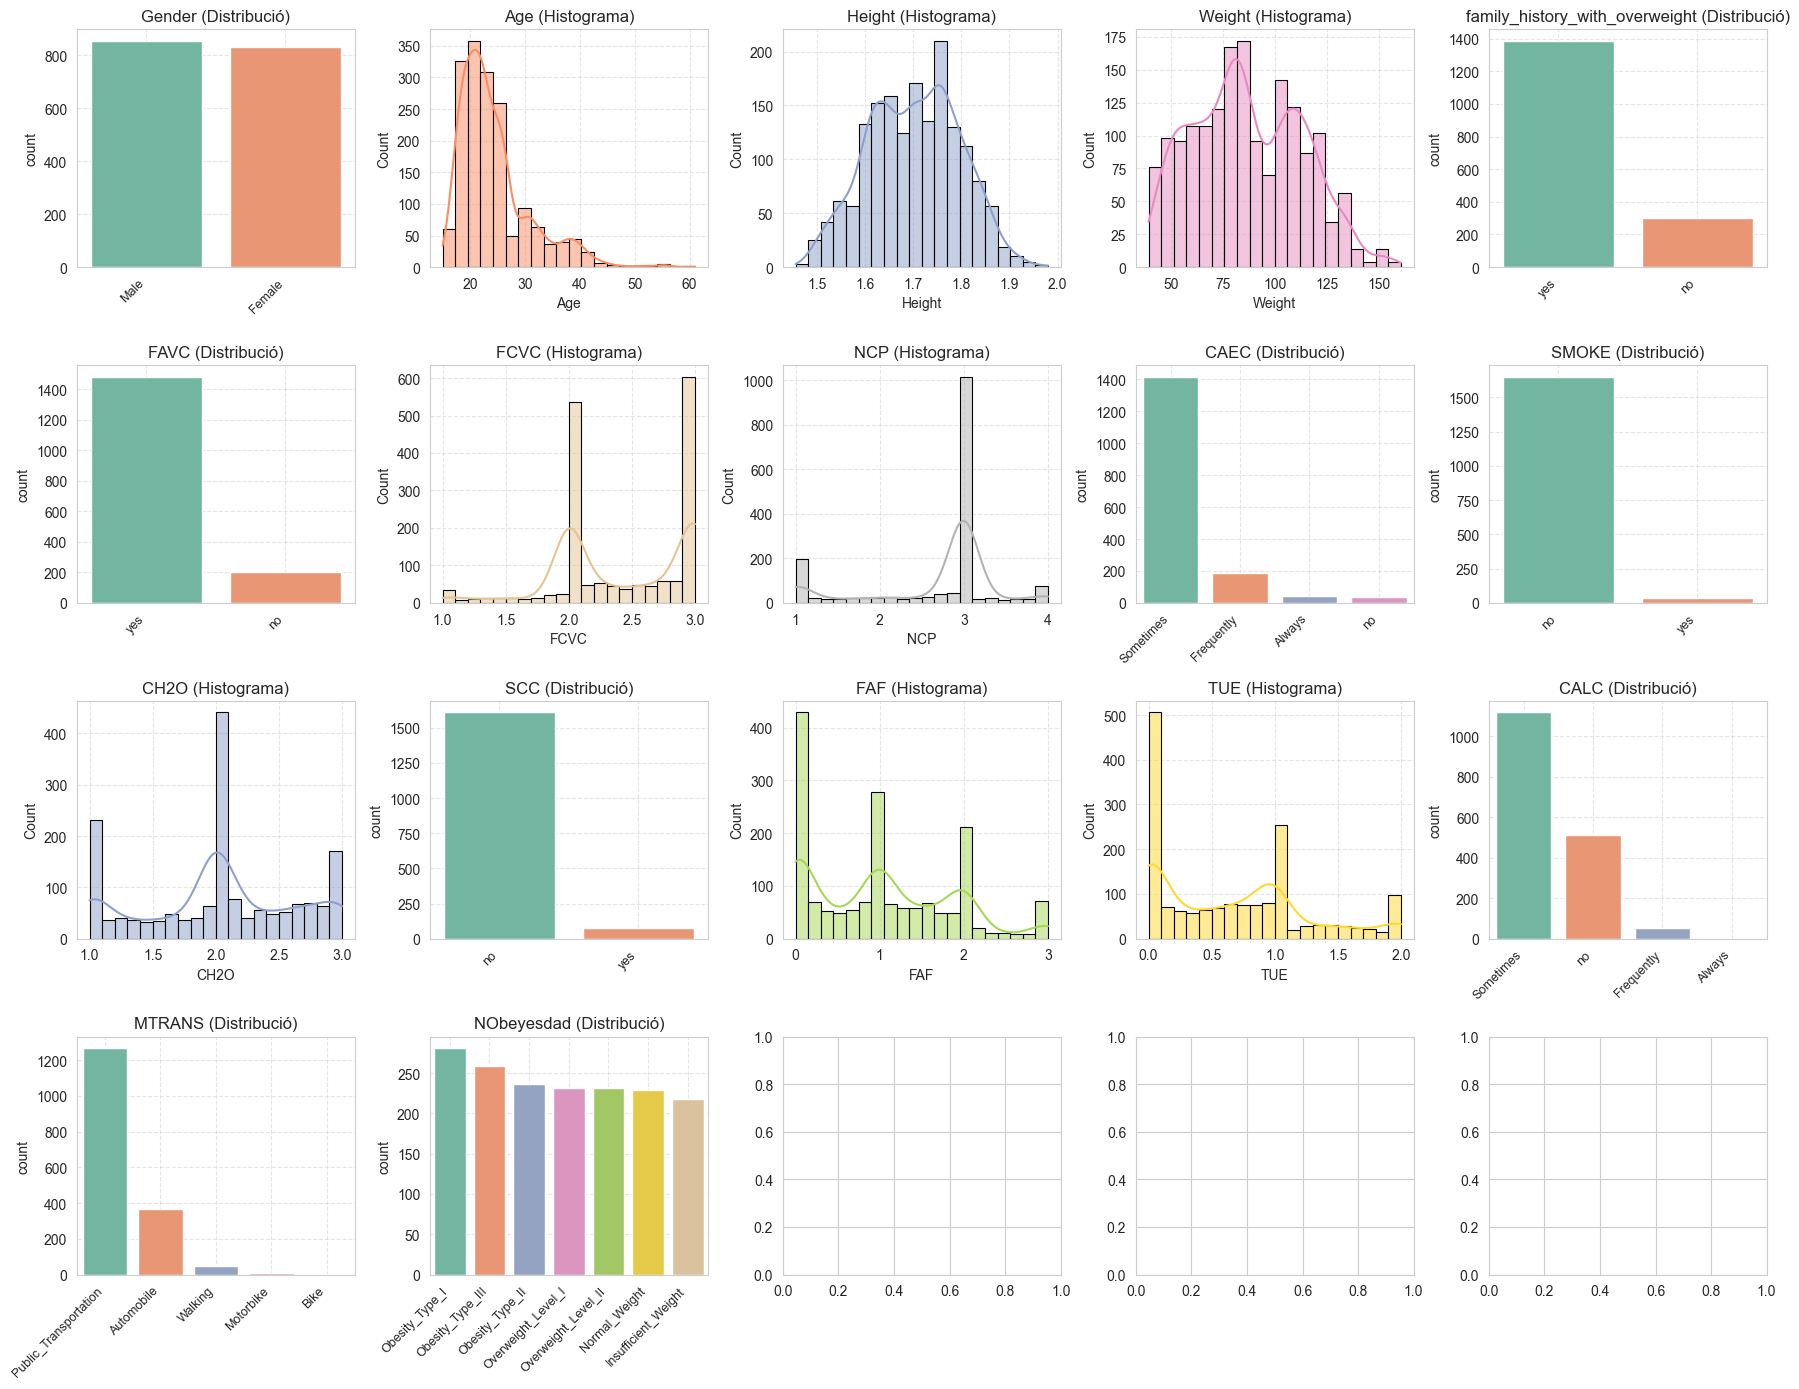

In [70]:
cols = df_tester.columns.tolist()

sns.set_style("whitegrid")
palette = sns.color_palette("Set2")

fig, axes = plt.subplots(4, 5, figsize=(18, 14))
axes = axes.flatten()

for i, col in enumerate(cols[:17]): 
    ax = axes[i]
    
    if (not pd.api.types.is_numeric_dtype(df_tester[col])) or (df_tester[col].nunique() <= 6):
        sns.countplot(
            x=df_split[col], 
            ax=ax, 
            order=df_split[col].value_counts().index, 
            palette=palette
        )
        ax.set_title(f'{col} (Distribució)')
        ax.set_xlabel('')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)

    else:
        sns.histplot(
            data=df_split, 
            x=col, 
            bins=20, 
            kde=True, # Afegim suavització (KDE)
            color=palette[i % len(palette)], # Assigna un color de la paleta
            edgecolor='black',
            ax=ax
        )
        ax.set_title(f'{col} (Histograma)', fontsize=12)
        ax.set_xlabel(col, fontsize=10)

    
    
    ax.grid(True, linestyle='--', alpha=0.5)

for j in range(i + 1, 17):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

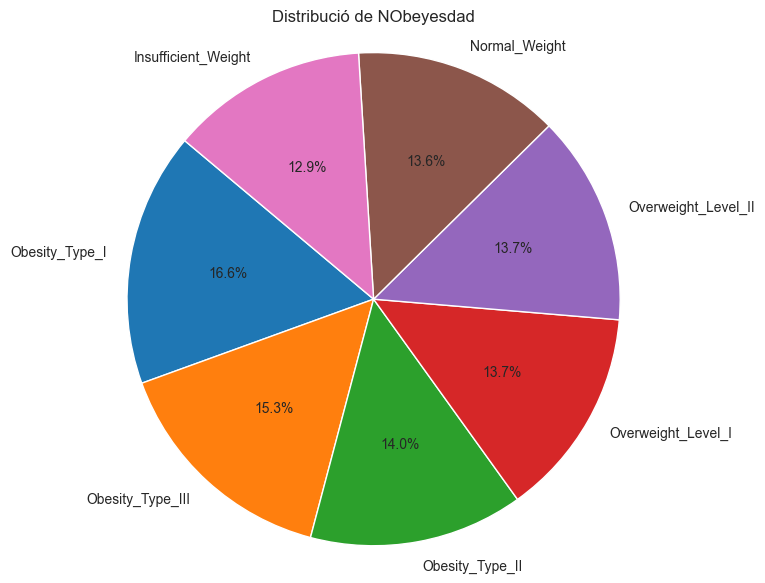

In [71]:
import matplotlib.pyplot as plt

counts = df_split['NObeyesdad'].value_counts()

plt.figure(figsize=(7, 7))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribució de NObeyesdad')
plt.axis('equal')
plt.show()

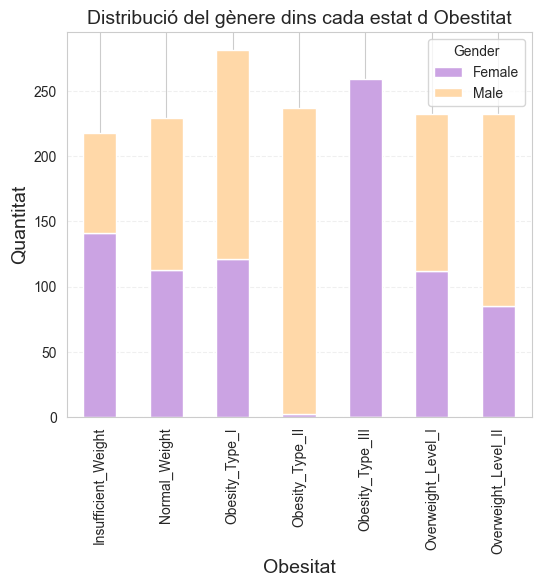

In [72]:
ct_rev = pd.crosstab(df_split["NObeyesdad"], df_split['Gender']) 

ct_rev.plot(kind='bar', stacked=True, 
            color=['#CBA3E3', '#FFD8A8'], 
            figsize=(6,5))

plt.title('Distribució del gènere dins cada estat d Obestitat', fontsize=14)
plt.xlabel('Obesitat', fontsize=14)
plt.ylabel('Quantitat', fontsize=14)
plt.grid(alpha=0.3, axis='y', linestyle='--')
plt.show()

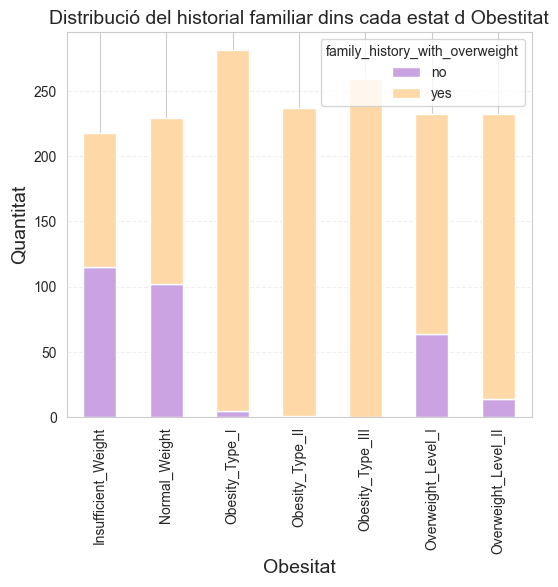

In [73]:
ct_rev = pd.crosstab(df_split["NObeyesdad"], df_split["family_history_with_overweight"]) 

ct_rev.plot(kind='bar', stacked=True, 
            color=['#CBA3E3', '#FFD8A8'], 
            figsize=(6,5))

plt.title('Distribució del historial familiar dins cada estat d Obestitat', fontsize=14)
plt.xlabel('Obesitat', fontsize=14)
plt.ylabel('Quantitat', fontsize=14)
plt.grid(alpha=0.3, axis='y', linestyle='--')
plt.show()

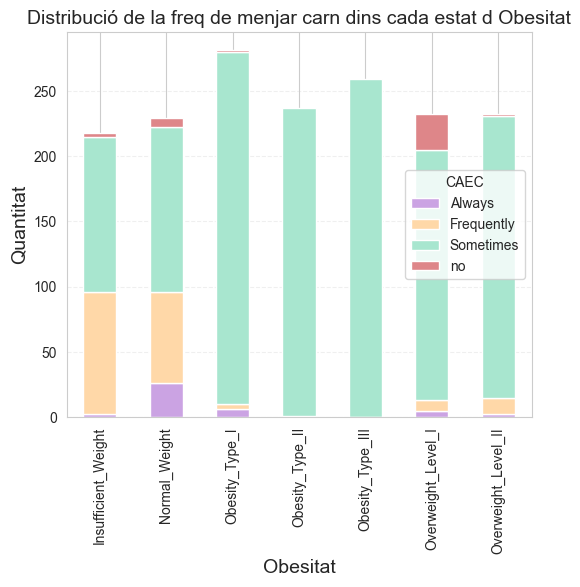

In [74]:
ct_rev = pd.crosstab(df_split["NObeyesdad"], df_split['CAEC'] ) 

ct_rev.plot(kind='bar', stacked=True, color=['#CBA3E3', '#FFD8A8', '#A8E6CF',"#DE8689"],
            figsize=(6,5))

plt.title('Distribució de la freq de menjar carn dins cada estat d Obesitat', fontsize=14)
plt.xlabel('Obesitat', fontsize=14)
plt.ylabel('Quantitat', fontsize=14)
plt.grid(alpha=0.3, axis='y', linestyle='--')
plt.show()

Comentem algo

Mirem si hi ha outliers

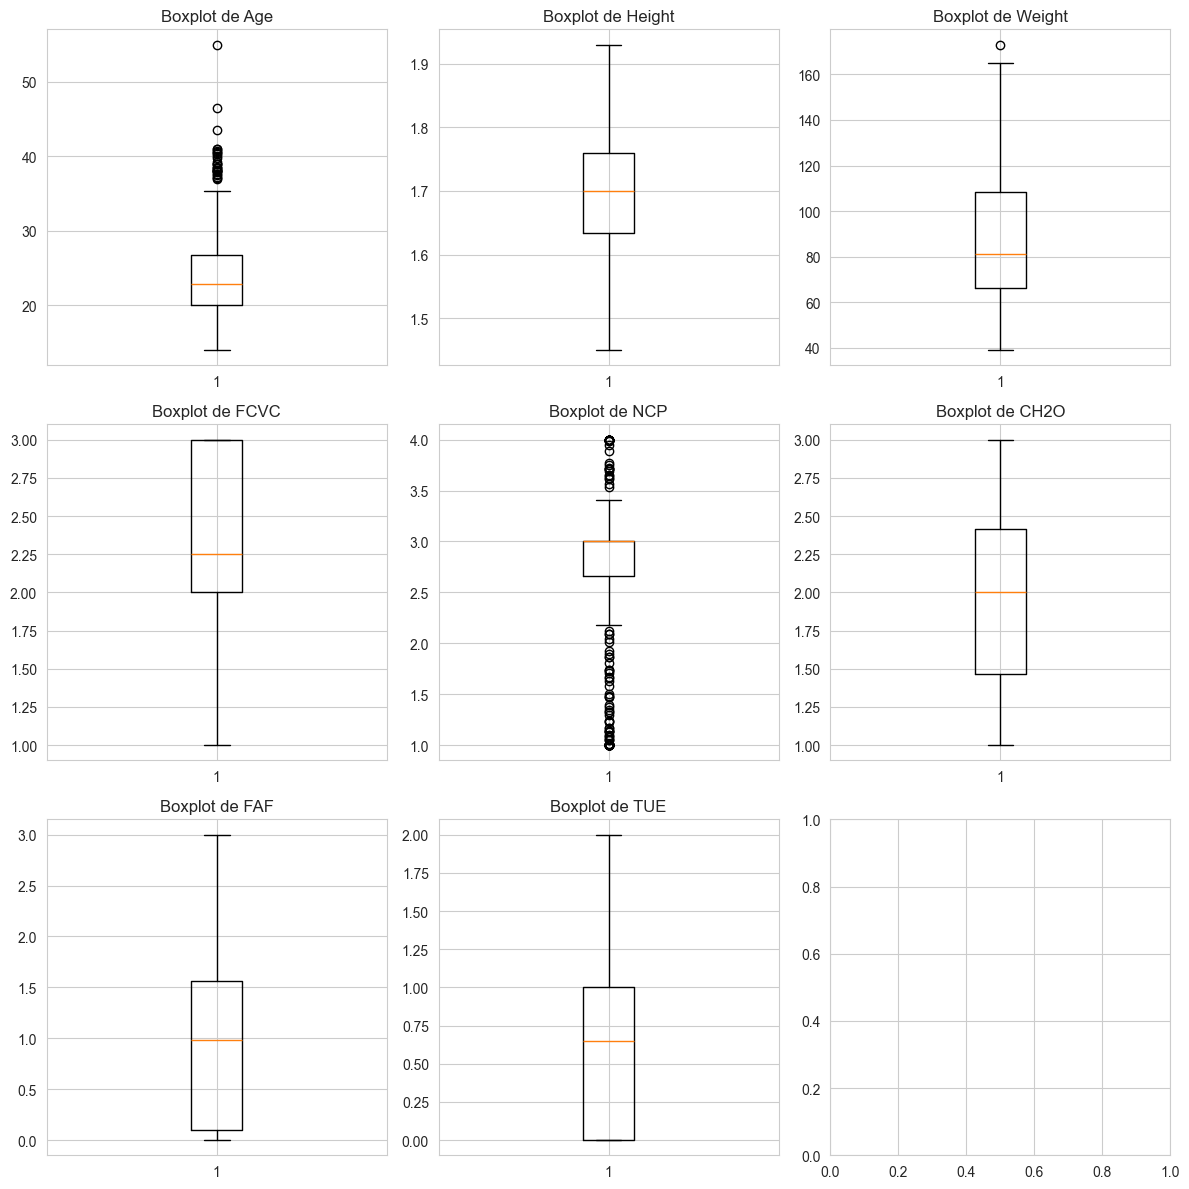

In [75]:
# Seleccionem només les variables numèriques
numeriques = df_tester.select_dtypes(include=['float64', 'int64']).columns

# Definim la quadrícula 3x2
fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # 3 files, 2 columnes
axes = axes.flatten()  # convertim a array 1D per iterar més fàcil

# Fem el boxplot per cada variable
for i, col in enumerate(numeriques[:8]):  # Només 6 variables per a 3x2
    axes[i].boxplot(df_tester[col])
    axes[i].set_title(f"Boxplot de {col}")

plt.tight_layout()
plt.show()

No veiem cap boxplot amb outliers importants, la variable NPC està entre valors del 0 al 4 i age entre 14 i 61. Però al normalitzar utilitzarem el z-score.

In [76]:
df_split = pd.get_dummies(df_split, columns=['MTRANS'])
df_split.head()

bool_cols = df_split.select_dtypes(include='bool').columns
df_split[bool_cols] = df_split[bool_cols].astype(int)

In [77]:
df_split['Gender'] = df_split['Gender'].replace({'Male': 1, 'Female': 0})
df_split['family_history_with_overweight'] = df_split['family_history_with_overweight'].replace({'yes': 1, 'no': 0})
df_split['FAVC'] = df_split['FAVC'].replace({'yes': 1, 'no': 0})
df_split['SMOKE'] = df_split['SMOKE'].replace({'yes': 1, 'no': 0})
df_split['SCC'] = df_split['SCC'].replace({'yes': 1, 'no': 0})
df_split['CALC'] = df_split['CALC'].replace({'Always': 3,'Frequently': 2,'Sometimes': 1, 'no': 0})
df_split['CAEC'] = df_split['CAEC'].replace({'Always': 3,'Frequently': 2,'Sometimes': 1, 'no': 0})

C:\Users\annit\AppData\Local\Temp\ipykernel_62236\632722537.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_split['Gender'] = df_split['Gender'].replace({'Male': 1, 'Female': 0})
C:\Users\annit\AppData\Local\Temp\ipykernel_62236\632722537.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_split['family_history_with_overweight'] = df_split['family_history_with_overweight'].replace({'yes': 1, 'no': 0})
C:\Users\annit\AppData\Local\Temp\ipykernel_62236\632722537.py:3: FutureWarning: Downcasting behavior in `replace` is dep

In [78]:
df_split.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,SCC,FAF,TUE,CALC,NObeyesdad,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
459,1,19.000000,1.760000,79.000000,1,1,2.000000,3.000000,2,0,...,0,1.000000,2.000000,2,Overweight_Level_I,0,0,0,1,0
426,1,22.000000,1.750000,70.000000,0,0,2.000000,3.000000,1,0,...,0,1.000000,1.000000,0,Normal_Weight,0,0,0,1,0
326,1,18.000000,1.700000,55.300000,1,1,3.000000,3.000000,1,0,...,0,3.000000,0.000000,1,Normal_Weight,0,0,0,1,0
971,1,19.506389,1.824449,87.656029,1,1,2.793561,3.788602,1,0,...,0,2.094542,0.393358,1,Overweight_Level_I,0,0,0,1,0
892,0,17.085250,1.535618,57.259124,0,1,1.972545,2.339614,1,0,...,1,0.095517,1.191053,1,Overweight_Level_I,0,0,0,1,0


Regressió de la variable resposta

In [79]:
df_split['NObeyesdad'] = df_split['NObeyesdad'].replace({'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2, 'Overweight_Level_II': 3, 'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6})

C:\Users\annit\AppData\Local\Temp\ipykernel_62236\2853249978.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_split['NObeyesdad'] = df_split['NObeyesdad'].replace({'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2, 'Overweight_Level_II': 3, 'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6})


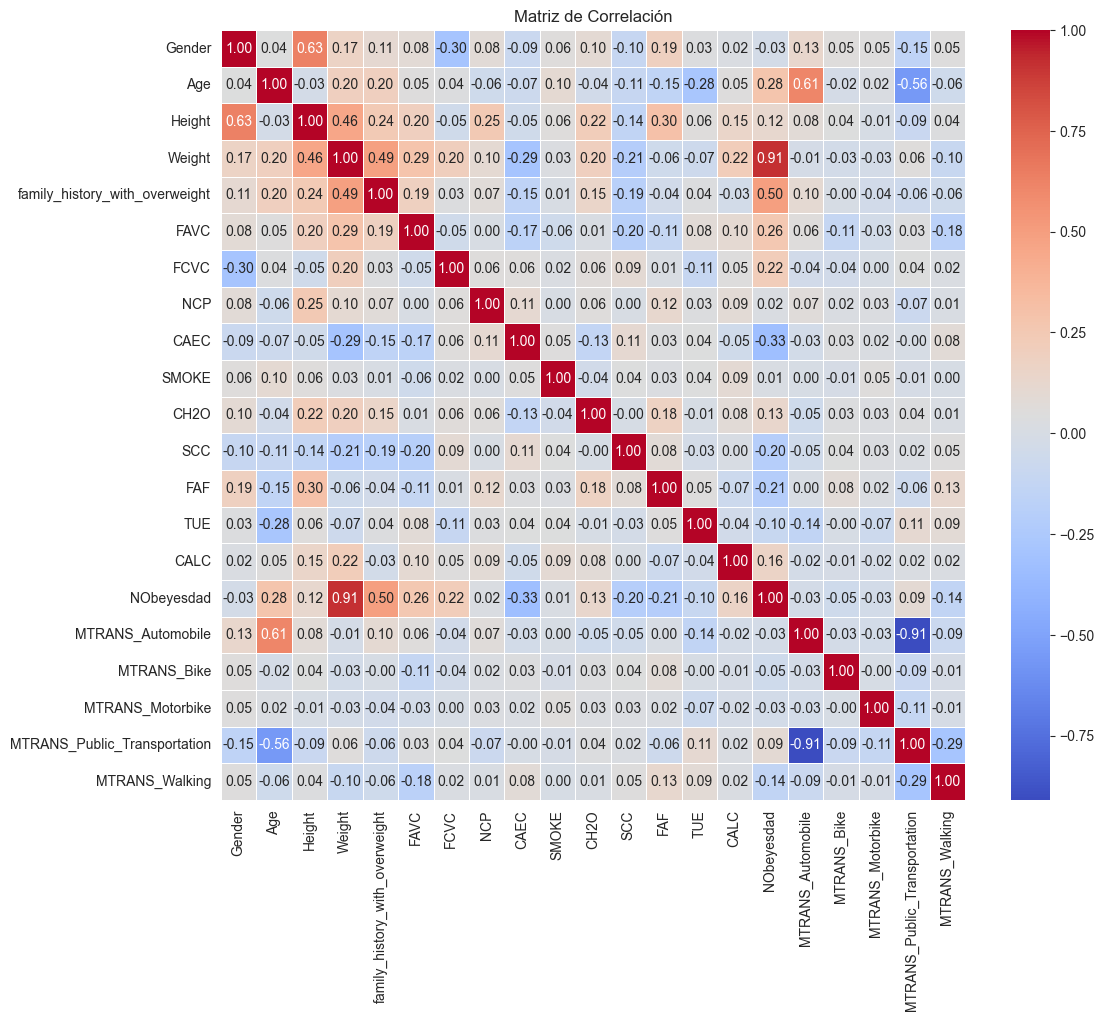

In [80]:
corr_matrix = df_split.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Matriz de Correlación')
plt.show()

Veiem que el pes té una correlació molt alta a la variable resposta. Cosa que té sentit ja que la classificació de NObeyesdad s'assigna de la segëunt manera segons el valor de BMI (body mass index):
- Underweight Less than 18.5
- Normal 18.5 to 24.9
- Overweight 25.0 to 29.9
- Obesity I 30.0 to 34.9
- Obesity II 35.0 to 39.9
- Obesity III Higher than 40

Per calcular el BMI: $ BMI = \frac{weight}{height^2}$. Veiem a la taula de correlacions que la variable Weight té molt de pes a la classificació del tipus d'obessitat, cosa que és obvia. Com el que volem és estudiar el pes que tenen la resta de variables no tant obvies, cosiderarem una nova base de dades que no tingui en compte la variable Height ni la variable Weight.

In [81]:
df_new= df_split.copy()
#borrem les variables pes i alçada
df_new= df_new.drop(columns=['Weight', 'Height'])
df_new.describe()

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,NObeyesdad,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
count,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000
mean,0.506517,24.310222,0.821682,0.879739,2.428400,2.688133,1.138626,0.021919,2.017965,0.046209,1.020554,0.653900,0.729265,3.111374,0.215640,0.002962,0.004147,0.750592,0.026659
std,0.500106,6.392643,0.382893,0.325362,0.529317,0.775336,0.464228,0.146464,0.613215,0.209999,0.847575,0.600574,0.516058,1.985284,0.411387,0.054360,0.064282,0.432798,0.161132
min,0.000000,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.918283,1.000000,1.000000,2.000000,2.663260,1.000000,0.000000,1.622384,0.000000,0.132315,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.000000,22.725431,1.000000,1.000000,2.414600,3.000000,1.000000,0.000000,2.000000,0.000000,1.000000,0.619850,1.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,26.000000,1.000000,1.000000,3.000000,3.000000,1.000000,0.000000,2.500827,0.000000,1.683612,1.000000,1.000000,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,61.000000,1.000000,1.000000,3.000000,4.000000,3.000000,1.000000,3.000000,1.000000,3.000000,2.000000,3.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000


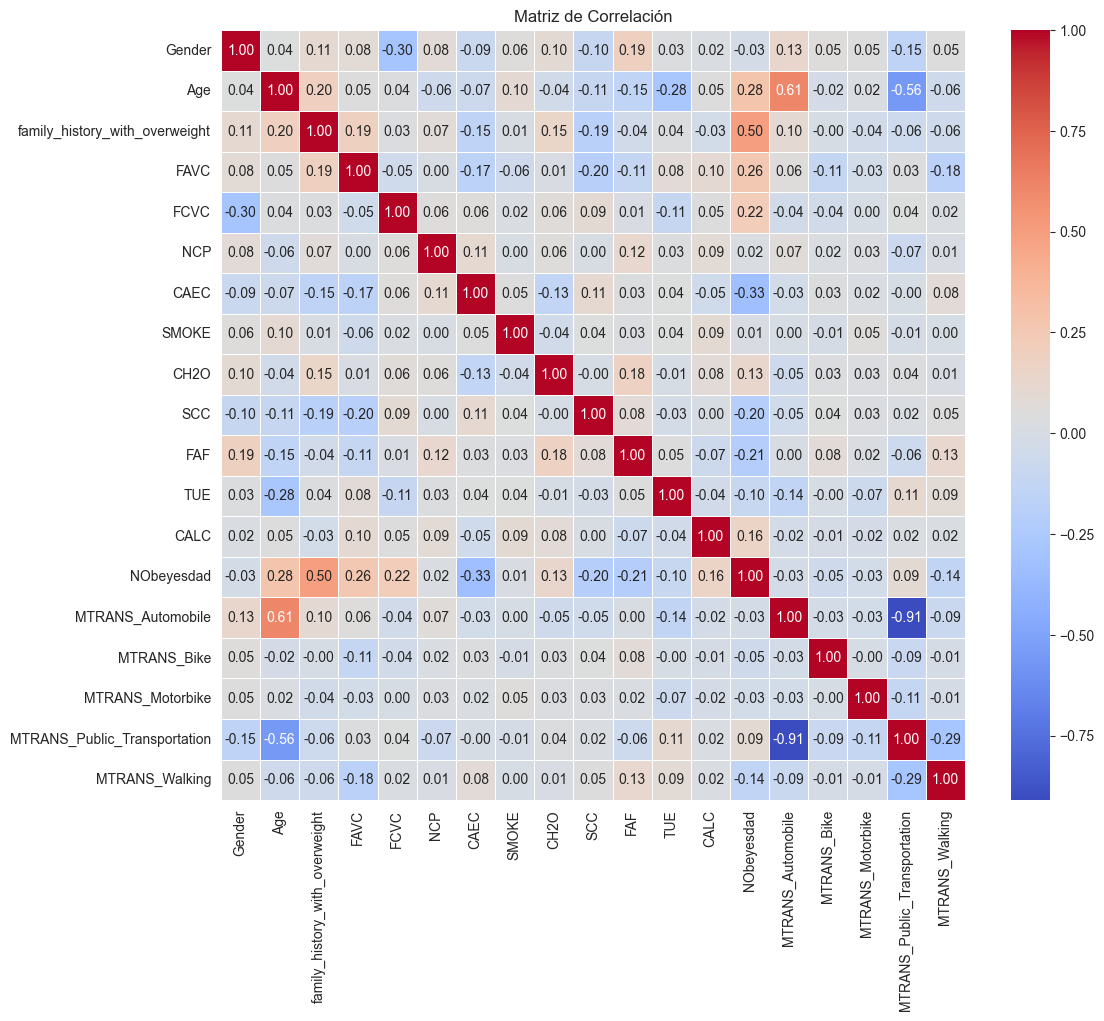

In [82]:
corr_matrix = df_new.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Matriz de Correlación')
plt.show()

(Cor)Relacions amb la variable NObeyesdad:
- Molt alta amb el pes. 
- Veiem que fumar no té correlació, podem treure la variable SMOKE. 
- L'historia de la familia té bastanta relació 
- La variable NCP té poc pes, haurem de mirar si volem eliminar-la.
- La variable transport(automobil) també té poc pes però està relacionada amb les altres de transport

Variables que estan correlaciones:
- Alçada amb el genere
- Alçada amb el pes
- PEs amb l'historial familiar
- Transport públic amb l'edat (invers)
- Automobil amb l'edat
- Transport públic amb l'automobil (invers)


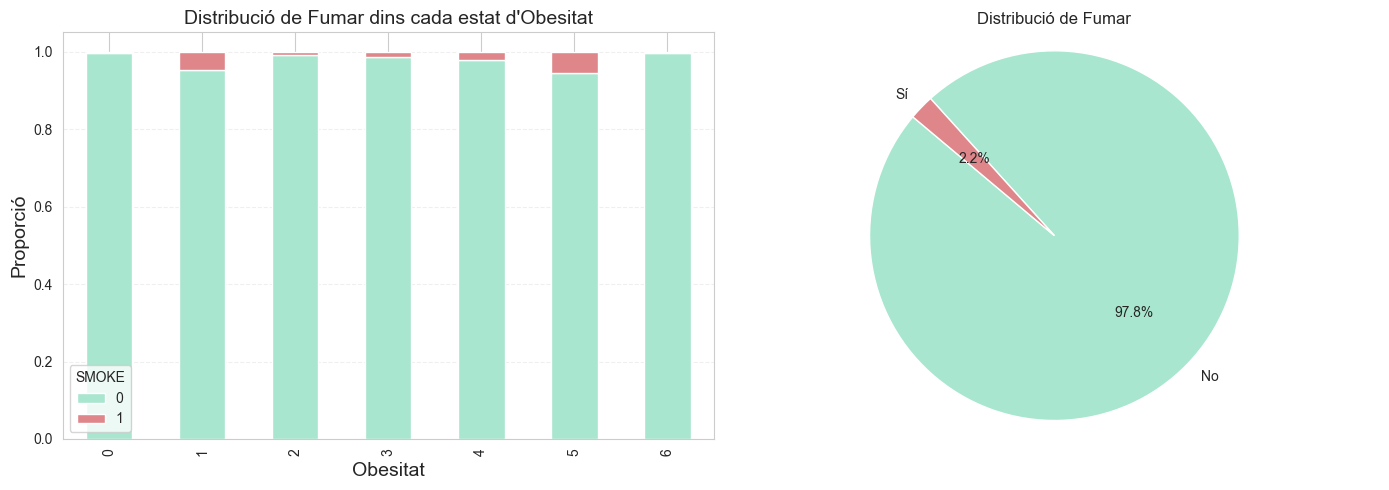

In [83]:
#Volem observar perq la variable smoke no te relacio amb l obesitat, potser que estigui desbalancejada --> per aixo és possible que no aporti info
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Gràfic 1: Distribució de fumar dins cada estat d'obesitat ---
ct_rev = pd.crosstab(df_new["NObeyesdad"], df_new['SMOKE'], normalize='index')

ct_rev.plot(kind='bar', stacked=True, color=['#A8E6CF',"#DE8689"], ax=axes[0])
axes[0].set_title('Distribució de Fumar dins cada estat d\'Obesitat', fontsize=14)
axes[0].set_xlabel('Obesitat', fontsize=14)
axes[0].set_ylabel('Proporció', fontsize=14)
axes[0].grid(alpha=0.3, axis='y', linestyle='--')

# --- Gràfic 2: Distribució global de fumadors ---
smoke_counts = df_new['SMOKE'].value_counts()

axes[1].pie(smoke_counts,
            labels=['No', 'Sí'],
            autopct='%1.1f%%',
            startangle=140,
            colors=['#A8E6CF',"#DE8689"])
axes[1].set_title('Distribució de Fumar')
axes[1].axis('equal')

plt.tight_layout()
plt.show()

Eliminem la variable SMOKE

In [84]:
df_clean = df_new[[c for c in df_new.columns if c != 'SMOKE']]


Ja hem passat les variables a numeriques, veiem que podem eliminar smoke, fem normalització i mirem si podem eliminar alguna variable més

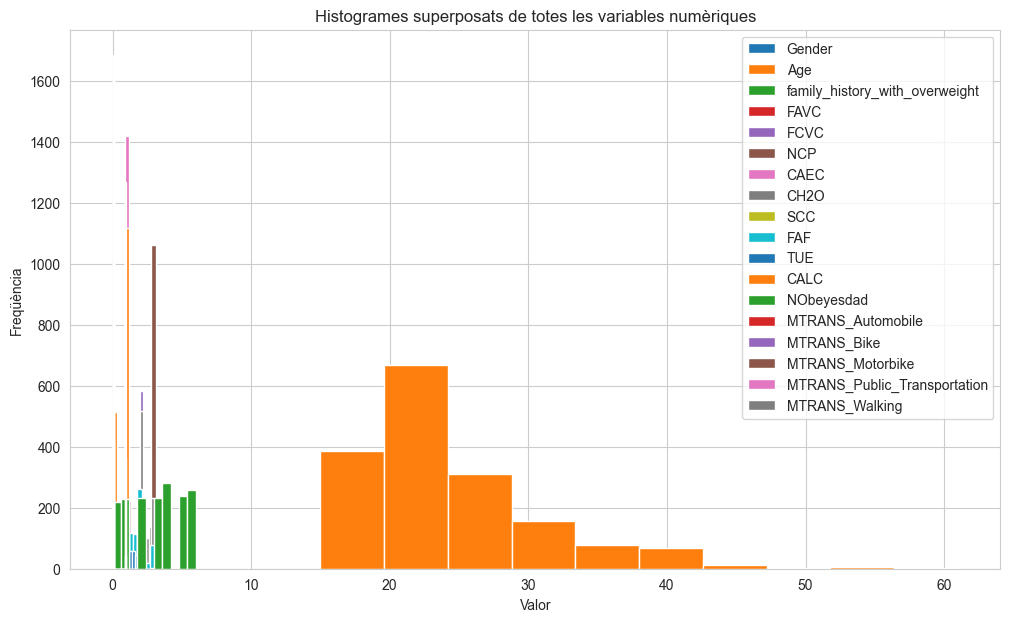

In [85]:
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns

# Fem l'histograma superposat
plt.figure(figsize=(12, 7))

for col in numeric_cols:
    plt.hist(df_clean[col], bins=10, alpha=1, label=col)

plt.title("Histogrames superposats de totes les variables numèriques")
plt.xlabel("Valor")
plt.ylabel("Freqüència")
plt.legend(loc='upper right', fontsize=10)
plt.show()

La normalització la fem amb z-score. Estem fent normalització a tota la base de dades, s'hauria de fer NOMÉS al training (desrpés del split)

C:\Users\annit\AppData\Local\Temp\ipykernel_62236\327701264.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = (df_clean[col] - train_means[col]) / train_stds[col]


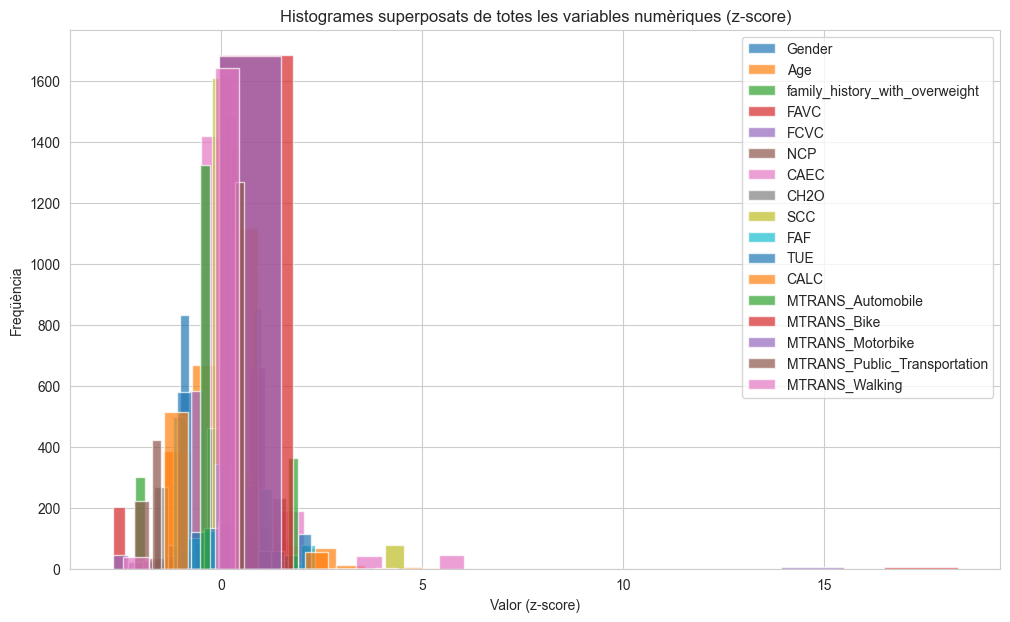

In [92]:
# Seleccionem només les columnes numèriques
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = [col for col in numeric_cols if col != 'NObeyesdad']

# Transformem a z-score
train_means = {}
train_stds = {}

for col in numeric_cols:
    train_means[col] = df_clean[col].mean()
    train_stds[col] = df_clean[col].std()
    df_clean[col] = (df_clean[col] - train_means[col]) / train_stds[col]

# Fem l'histograma superposat
plt.figure(figsize=(12, 7))

for col in numeric_cols:
    plt.hist(df_clean[col], bins=10, alpha=0.7, label=col)  # alpha=0.5 per veure superposició

plt.title("Histogrames superposats de totes les variables numèriques (z-score)")
plt.xlabel("Valor (z-score)")
plt.ylabel("Freqüència")
plt.legend(loc='upper right', fontsize=10)
plt.show()


In [94]:
X = df_clean[[c for c in df_clean.columns if c != 'NObeyesdad']]
y = df_clean['NObeyesdad']

Comprovem si cal eliminar alguna variable amb Lasso

In [95]:
model_lasso = Lasso(alpha=0.05)
model_lasso.fit(X, y) #no se si hauriem de posar X_train i y_train o X i y

coef = pd.Series(model_lasso.coef_, index=X.columns)
print("\nCoeficients del model LASSO:")
display(coef.sort_values(key=abs, ascending=False).to_frame("Pes de la variable"))


Coeficients del model LASSO:


,Pes de la variable
family_history_with_overweight,0.731803
Age,0.476421
CAEC,-0.417845
MTRANS_Public_Transportation,0.367524
FCVC,0.358070
FAF,-0.205248
CALC,0.181302
FAVC,0.177726
SCC,-0.107606
MTRANS_Automobile,-0.047625


Lasso ens elimina la majoria de variables, només ens quedem amb Weight, Height, family_history_with_overweight. 

Potser Lasso no acaba de ser del tot eficient ja que tenim algunes variables altament correlacionades:
- MTRANS_Automobile - Age
- MTRANS_Public_Transportation - Age
- MTRANS_Automobile - MTRANS_Public_Transportation
- Hight - Gender


Provem de fer la selecció de variables amb Ridge

In [96]:
model_ridge = Ridge()
model_ridge.fit(X,y)

coef = pd.Series(model_ridge.coef_, index=X.columns)
print("\nCoeficients del model Ridge:")
display(coef.sort_values(key=abs, ascending=False).to_frame("Pes de la variable"))


Coeficients del model Ridge:


,Pes de la variable
family_history_with_overweight,0.744160
Age,0.576182
CAEC,-0.454212
FCVC,0.392982
MTRANS_Public_Transportation,0.266182
MTRANS_Automobile,-0.263706
FAF,-0.243010
FAVC,0.213490
CALC,0.204812
SCC,-0.141861


Provem el pes que adjudica randomforest i shap (mira les relacions no lineals també)

,Pes de la variable
family_history_with_overweight,0.246587
CAEC,0.130350
Age,0.127219
FCVC,0.124971
FAF,0.069396
NCP,0.067137
TUE,0.055182
MTRANS_Public_Transportation,0.050986
Gender,0.044855
CALC,0.026303


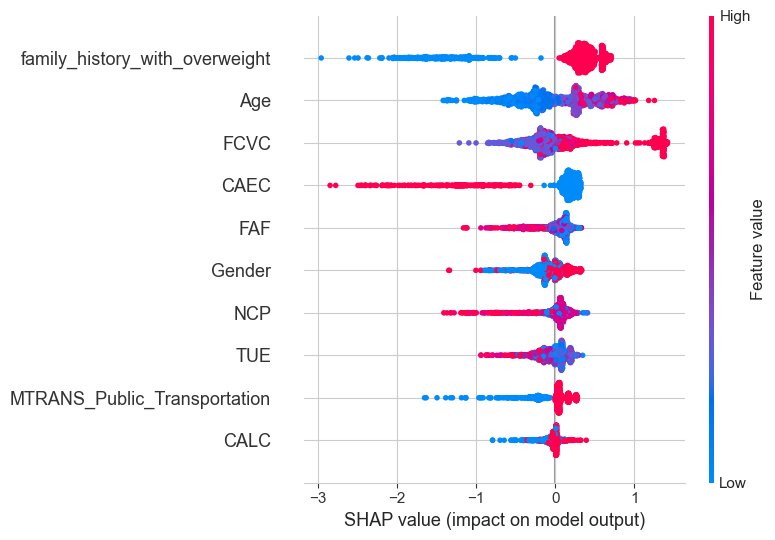

None


In [97]:
#Si vols selecció de variables fiable per prediccions, sobretot amb pocs features (21) i combinacions complexes → SHAP és millor.
#Random Forest feature importance està bé per un primer filtratge ràpid, però no és tan fiable com SHAP quan hi ha correlacions o interaccions.
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
display(importances.sort_values(ascending=False).to_frame("Pes de la variable"))

import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)
print(shap.summary_plot(shap_values, X,max_display=10))

Lasso considera les variables FAVC i SCC amb més pes i Random forest, Gender i NCP.

Ens quedem amb les variables que ha predit el random forest /shap ja que té en compte també relacions no lineals.

Base de dades reduïda

In [98]:
df_reduit = df_clean[['family_history_with_overweight', 'FCVC',  'Age', 'CAEC','MTRANS_Public_Transportation', 'Gender','FAF', 'NCP', 'TUE','CALC', 'NObeyesdad']]

In [99]:
X_red = df_reduit[[c for c in df_reduit.columns if c != 'NObeyesdad']]
y_red = df_reduit['NObeyesdad']

## Metric selection
Hem de triar una mètrica per comparar models:
- R²: compara la variància total de la variable dependent amb la variància que el model no ha pogut explicar, si el model te poca variancia, surt un r2 baix i potser molt bo i fa creure que el model no generalitza, tot i que sí ho fa.
- MAE (el que utlitzarem): Serveix per mesurar com d’equivocat està un model, de mitjana, sense exagerar els errors grans.si la MAE és baixa el model és millor.
- RMSE: mesura com s’equivoca el model però penalitzant més fortament els errors grans (eleva els errors al quadrat).
És útil si volem posar més pes als casos on la predicció falla molt. Si n'hi un de molt gran la metrica li dona molt de pes. (dubto amb aquest)

De moment utilitzem RMSE, penalitza els errors més grans

## Model selection

Algoritmes que utilitzarem:
- Regressió lineal.
- Random Forest
- Gradient boosting (XGBoost,LightGBM)
- SVR

## Validació creuada
Fem validació creuada amb els hiperparàmetres per defecte, per tenir una primera impressió. 

hauriem de mirar quants k folds fem, no cal separar les dades perq el cros validation ja ho fa en cada iteracio

In [106]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

models = {
        "LinearRegression": LinearRegression(),
        "RandomForest": RandomForestRegressor(),
        "XGBoost": XGBRegressor(),
        "LightGBM": LGBMRegressor(),
        "SVR": SVR()
}
cv_scores = {'LinearRegression': [], 'RandomForest': [], 'XGBoost': [], 'LightGBM': [], 'SVR': []}
cv_scores_mean = {'LinearRegression': [], 'RandomForest': [], 'XGBoost': [], 'LightGBM': [], 'SVR': []}
test_scores = {'LinearRegression': [], 'RandomForest': [], 'XGBoost': [], 'LightGBM': [], 'SVR': []}
total_times = {'LinearRegression': [], 'RandomForest': [], 'XGBoost': [], 'LightGBM': [], 'SVR': []}

cv = KFold(n_splits=5,shuffle=True) 
rmse_scorer = make_scorer(rmse)

for name, model in models.items():
    start_time = time.time()
    cv_rmse_values = cross_val_score(model, X_red, y_red, cv=cv, scoring=rmse_scorer)
    end_time = time.time()
    
    cv_scores[name].extend(cv_rmse_values)            # per al boxplot
    cv_scores_mean[name].append(cv_rmse_values.mean())  # per a la taula
    total_times[name].append(end_time - start_time)


# Crear taula resum amb mitjanes
results = pd.DataFrame({
    'Model': ['LinearRegression', 'RandomForest', 'XGBoost', 'LightGBM', 'SVR'],
    'Validació RMSE (mitjana)': [
        np.mean(cv_scores_mean['LinearRegression']),
        np.mean(cv_scores_mean['RandomForest']),
        np.mean(cv_scores_mean['XGBoost']),
        np.mean(cv_scores_mean['LightGBM']),
        np.mean(cv_scores_mean['SVR'])
    ],
    'Temps total (s)': [  # canviat el nom
        np.mean(total_times['LinearRegression']),
        np.mean(total_times['RandomForest']),
        np.mean(total_times['XGBoost']),
        np.mean(total_times['LightGBM']),
        np.mean(total_times['SVR'])
    ]
})

# Mostrar taula formatejada
styled = (
    results.style
    .set_caption("Comparació de models amb RMSE i temps total (validació creuada 5-fold)")
    .format({
        'Validació rmse (mitjana)': '{:.3f}',
        'Temps total (s)': '{:.4f}'
    })
)

styled

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1292
[LightGBM] [Info] Number of data points in the train set: 1350, number of used features: 10
[LightGBM] [Info] Start training from score 3.116296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1292
[LightGBM] [Info] Number of data points in the train set: 1350, number of used features: 10
[LightGBM] [Info] Start training from score 3.123704
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1292
[LightGBM] [Info] Number of data points in the train set: 1350, number of used features: 10
[LightGBM] [Info] Start traini

,Model,Validació RMSE (mitjana),Temps total (s)
0,LinearRegression,1.443184,0.0256
1,RandomForest,0.762344,2.2272
2,XGBoost,0.805132,0.8005
3,LightGBM,0.773495,0.5677
4,SVR,0.882230,0.4173


C:\Users\annit\AppData\Local\Temp\ipykernel_62236\809432310.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([cv_scores[m] for m in models.keys()], labels=models.keys())


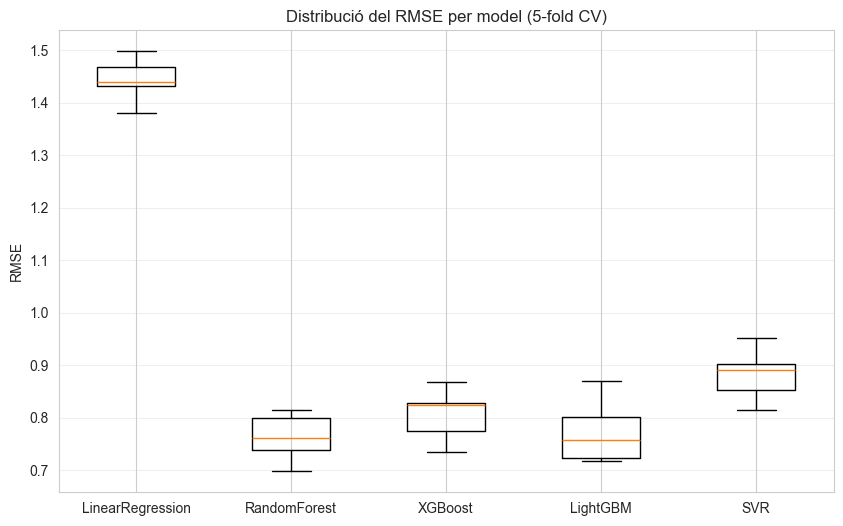

In [107]:
plt.figure(figsize=(10,6))
plt.boxplot([cv_scores[m] for m in models.keys()], labels=models.keys())
plt.ylabel("RMSE")
plt.title("Distribució del RMSE per model (5-fold CV)")
plt.grid(axis='y', alpha=0.3)
plt.show()


Volem un valor RMSE baix. De moment amb els hiperparàmetres per defecte, obtenim millors resultats amb el RandomForest, XGBoost i LightGBM. Així que farem la cerca d'hiperparametres dels models més prometedors per tal d'estalviar temps de computació.

## Cerca d'hiperparàmetres

### RandomForest

In [ ]:
param = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

cv = KFold(n_splits = 5)
rmse_scorer = make_scorer(rmse,greater_is_better=False)


grid_search = GridSearchCV(RandomForestRegressor(), param, scoring = rmse_scorer, cv = cv,n_jobs=-1)
grid_search.fit(X_red, y_red)

print("Millors hiperparàmetres trobats RandomForest:")
print(grid_search.best_params_)
print(f"RMSE (mitjà CV): {-grid_search.best_score_:.4f}")



Millors hiperparàmetres trobats RandomForest:
{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
RMSE (mitjà CV): 0.7669


### XGBoost

In [ ]:
# Hiperparàmetres 
param_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(rmse, greater_is_better=False)  # important: per GridSearchCV, RMSE ha de ser negatiu

# GridSearchCV
grid_search_xgb = GridSearchCV(
    XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_xgb,
    scoring=rmse_scorer,
    cv=cv,
    n_jobs=-1
)

# Entrenar i buscar millors hiperparàmetres
grid_search_xgb.fit(X_red, y_red)

# Resultats
print("Millors hiperparàmetres trobats XGBoost:")
print(grid_search_xgb.best_params_)
print(f"RMSE Validació (mitjana): {-grid_search_xgb.best_score_:.4f}")


Millors hiperparàmetres trobats XGBoost:
{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.7}
RMSE Validació (mitjana): 0.7353


### LightGBM

In [ ]:
# Hiperparàmetres 
param_lgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],   
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100]
}

# KFold per CV
cv = KFold(n_splits=5, shuffle=True)
rmse_scorer = make_scorer(rmse, greater_is_better=False)  # RMSE: valors més petits són millors

# GridSearchCV
grid_search_lgb = GridSearchCV(
    LGBMRegressor(random_state=42),
    param_grid=param_lgb,
    scoring=rmse_scorer,
    cv=cv,
    n_jobs=-1, # va amb paral·lel, mes rapid
)

# Entrenar i buscar millors hiperparàmetres
grid_search_lgb.fit(X_red, y_red)

# Resultats
print("Millors hiperparàmetres trobats LightGBM:")
print(grid_search_lgb.best_params_)
print(f"RMSE Validació (mitjana): {-grid_search_lgb.best_score_:.4f}")



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1293
[LightGBM] [Info] Number of data points in the train set: 1688, number of used features: 10
[LightGBM] [Info] Start training from score 3.111374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [111]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

models_best = {
    "RandomForest": grid_search.best_estimator_,
    "XGBoost": grid_search_xgb.best_estimator_,
    "LightGBM": grid_search_lgb.best_estimator_,
}

# --- 3. Cross-validation amb els millors models ---
cv_scores = {name: [] for name in models_best}
cv_scores_mean = {name: [] for name in models_best}
total_times = {name: [] for name in models_best}

for name, model in models_best.items():
    start_time = time.time()
    cv_rmse_values = cross_val_score(model, X_red, y_red, cv=cv, scoring=rmse_scorer)
    end_time = time.time()
    
    cv_scores[name].extend(-cv_rmse_values)
    cv_scores_mean[name].append((-cv_rmse_values).mean())
    total_times[name].append(end_time - start_time)

# --- 4. Crear taula resum amb mitjanes ---
results = pd.DataFrame({
    'Model': list(models_best.keys()),
    'Validació RMSE (mitjana)': [np.mean(cv_scores_mean[name]) for name in models_best],
    'Temps total (s)': [np.mean(total_times[name]) for name in models_best]
})

# --- 5. Mostrar taula formatejada ---
styled = (
    results.style
    .set_caption("Comparació de models amb RMSE i temps total (validació creuada 5-fold)")
    .format({
        'Train CV RMSE (mitjana)': '{:.3f}',
        'Temps total (s)': '{:.4f}'
    })
)

styled

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1294
[LightGBM] [Info] Number of data points in the train set: 1350, number of used features: 10
[LightGBM] [Info] Start training from score 3.089630
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

,Model,Validació RMSE (mitjana),Temps total (s)
0,RandomForest,0.760119,4.7671
1,XGBoost,0.751262,2.0691
2,LightGBM,0.796430,0.6599


### Boxplot de comparacio de models amb els hiperparametres triats

C:\Users\annit\AppData\Local\Temp\ipykernel_62236\3691239346.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([cv_scores[m] for m in models_best.keys()], labels=models_best.keys())


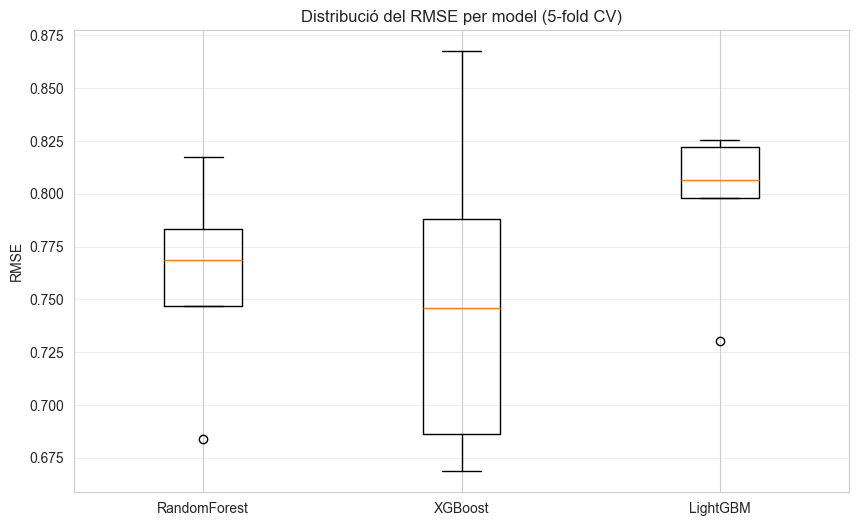

In [112]:
plt.figure(figsize=(10,6))
plt.boxplot([cv_scores[m] for m in models_best.keys()], labels=models_best.keys())
plt.ylabel("RMSE")
plt.title("Distribució del RMSE per model (5-fold CV)")
plt.grid(axis='y', alpha=0.3)
plt.show()


El millor model és el XGBoost amb els hiperparàmetres: learning_rate: 0.1, max_depth: 10, n_estimators: 100, subsample: 0.7

## Anàlisi final

Preparem el dataset que ens servirà per fer el test

In [113]:
nan_counts=df_tester.isna().sum()
var_type = df_tester.dtypes

print("Valors NaN per atribut i tipus de variable:")
print(pd.DataFrame({"NaN Count": nan_counts, "Variable Type": var_type}))

Valors NaN per atribut i tipus de variable:
                                NaN Count Variable Type
Gender                                  0        object
Age                                     0       float64
Height                                  0       float64
Weight                                  0       float64
family_history_with_overweight          0        object
FAVC                                    0        object
FCVC                                    0       float64
NCP                                     0       float64
CAEC                                    0        object
SMOKE                                   0        object
CH2O                                    0       float64
SCC                                     0        object
FAF                                     0       float64
TUE                                     0       float64
CALC                                    0        object
MTRANS                                  0        object
NObe

No hi ha valors NaN.
Tenim les mateixes variables que amb training, per tant fem one-hot encoding per la variable MTRANS, i convertim en numèriques les variables categòriques Gender, amily_history_with_overweight, FAVC, SMOKE, SCC, CALC, CAEC

In [114]:
df_tester = pd.get_dummies(df_tester, columns=['MTRANS'])

bool_cols = df_tester.select_dtypes(include='bool').columns
df_tester[bool_cols] = df_tester[bool_cols].astype(int)

df_tester['Gender'] = df_tester['Gender'].replace({'Male': 1, 'Female': 0})
df_tester['family_history_with_overweight'] = df_tester['family_history_with_overweight'].replace({'yes': 1, 'no': 0})
df_tester['FAVC'] = df_tester['FAVC'].replace({'yes': 1, 'no': 0})
df_tester['SMOKE'] = df_tester['SMOKE'].replace({'yes': 1, 'no': 0})
df_tester['SCC'] = df_tester['SCC'].replace({'yes': 1, 'no': 0})
df_tester['CALC'] = df_tester['CALC'].replace({'Always': 3,'Frequently': 2,'Sometimes': 1, 'no': 0})
df_tester['CAEC'] = df_tester['CAEC'].replace({'Always': 3,'Frequently': 2,'Sometimes': 1, 'no': 0})

# Regressió de la variable resposta
df_tester['NObeyesdad'] = df_tester['NObeyesdad'].replace({'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2, 'Overweight_Level_II': 3, 'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6})


C:\Users\annit\AppData\Local\Temp\ipykernel_62236\334919169.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_tester['Gender'] = df_tester['Gender'].replace({'Male': 1, 'Female': 0})
C:\Users\annit\AppData\Local\Temp\ipykernel_62236\334919169.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_tester['family_history_with_overweight'] = df_tester['family_history_with_overweight'].replace({'yes': 1, 'no': 0})
C:\Users\annit\AppData\Local\Temp\ipykernel_62236\334919169.py:8: FutureWarning: Downcasting behavior in `replace` is

In [118]:
# Ens quedem amb les variables seleccionades amb RandomForest
df_tester = df_tester[['family_history_with_overweight', 'FCVC',  'Age', 'CAEC','MTRANS_Public_Transportation', 'Gender','FAF', 'NCP', 'TUE','CALC', 'NObeyesdad']]

In [119]:
#normalitzem´
# Seleccionem només les columnes numèriques
numeric_cols = df_tester.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = [col for col in numeric_cols if col != 'NObeyesdad']

for col in numeric_cols:
    df_tester[col] = (df_tester[col] - train_means[col]) / train_stds[col]

C:\Users\annit\AppData\Local\Temp\ipykernel_62236\2712721462.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tester[col] = (df_tester[col] - train_means[col]) / train_stds[col]


In [142]:
final_model = XGBRegressor(learning_rate = 0.1, max_depth = 10, n_estimators = 200)

final_model.fit(X_red, y_red)

X_test = df_tester[[col for col in df_tester if col != 'NObeyesdad']]
y_test = df_tester['NObeyesdad']

y_pred = final_model.predict(X_test)

print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")


RMSE: 1.6243303826645363


El model final ens dona un RMSE de 1,62 per poder comparar amb el model de classificació transformarem els valors predits en nombres enters (0 al 6) i utilitzarem una metrica de classificació (Accuracy).

## Canvi a classificació

In [139]:
y_pred_class = np.floor(y_pred + 0.5).astype(int)
y_pred_class = np.clip(y_pred_class, 0, 6)

In [140]:
y_pred_class

array([0, 1, 3, 4, 3, 2, 3, 2, 2, 2, 1, 2, 4, 1, 2, 1, 2, 2, 2, 1, 1, 3,
       3, 3, 2, 0, 3, 4, 2, 4, 3, 2, 2, 2, 1, 1, 3, 0, 4, 0, 2, 0, 4, 4,
       2, 4, 1, 2, 2, 2, 4, 1, 0, 2, 3, 0, 4, 4, 4, 3, 2, 3, 2, 2, 3, 3,
       2, 0, 3, 1, 4, 1, 0, 0, 3, 1, 0, 1, 3, 2, 1, 4, 4, 2, 1, 2, 3, 1,
       1, 2, 3, 3, 3, 3, 1, 1, 0, 1, 4, 3, 3, 3, 1, 1, 3, 4, 2, 3, 2, 3,
       1, 1, 4, 3, 4, 4, 0, 4, 1, 1, 4, 2, 4, 1, 2, 2, 0, 3, 3, 3, 4, 2,
       1, 0, 0, 1, 1, 1, 1, 0, 4, 3, 3, 2, 2, 4, 3, 3, 2, 3, 3, 1, 4, 0,
       3, 4, 4, 3, 4, 1, 1, 4, 4, 2, 4, 3, 1, 3, 3, 3, 2, 2, 1, 4, 0, 2,
       2, 1, 3, 3, 2, 1, 3, 3, 1, 0, 3, 4, 1, 1, 1, 0, 4, 3, 2, 2, 0, 2,
       2, 3, 3, 4, 2, 3, 1, 0, 2, 3, 1, 1, 0, 4, 2, 2, 3, 1, 2, 3, 1, 2,
       1, 4, 1, 2, 3, 3, 1, 4, 2, 2, 3, 1, 3, 4, 3, 2, 2, 2, 2, 2, 4, 3,
       4, 2, 2, 3, 1, 1, 2, 3, 2, 0, 4, 3, 3, 4, 3, 2, 2, 4, 4, 2, 3, 2,
       4, 2, 3, 4, 1, 2, 3, 0, 4, 2, 3, 4, 3, 0, 3, 4, 3, 4, 4, 1, 1, 1,
       1, 3, 3, 4, 1, 1, 1, 2, 2, 0, 2, 3, 3, 3, 4,

In [143]:
accuracy_score(y_test, y_pred_class)

0.22695035460992907